## Notebook Setup and Uploading of Data to S3

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
!pip install -Uq altair torchtext torchdata

In [4]:
import sagemaker

In [5]:
!mkdir -p nn_gen_src
import sys
sys.path.append('nn_src')
sys.path.append('nn_gen_src')

In [6]:
!touch nn_gen_src/train_dummy
BUCKET = sagemaker.Session().default_bucket()
s3_data_url = f's3://{BUCKET}/nn/'
!aws s3 sync nn_gen_src {s3_data_url} --exclude '*' --include 'train_dummy'

upload: nn_gen_src/train_dummy to s3://sagemaker-eu-west-1-811243659808/nn/train_dummy


!0!2.0
!1!1.5
!2!1.3
!3!1.3 (last improvement)
!4!1.4
!5!1.5
!6!1.6



In [448]:
# Uncomment the following line when you want to test your script locally (validate arg parsing for example)
#!python nn_src/train.py --epochs 20 --kernel-sizes '[1, 3]' --model 'CNN' --dim 32 --strides '[1, 1]' --num-filters '[12, 12]'

In [500]:
# Uncomment below to directly call the implementation. 
# To check if you have typos or mismatched dimensions, before you submit it to a container training.
# But also for example use PDB.
from nn_src.train import main as fit
fit('--epochs', 20,
    '--vocab-size', 1_000,
    '--batch-size', 128,
    '--lr', 1e-1, 
    '--layers', 1,
    '--dim', 8,
    '--ff-dim', 4,
    '--heads', 4,
    '--max-input-len', 64,
    '--early-stopping-patience', 2,
    '--clf-scale', 0.,
    '--model', 'CNN',
    '--dim', 32,
    '--strides', [1, 1],
    '--num-filters', [12, 12],
    '--kernel-sizes', [1, 3],
    '--tokenizer', 'basic'
)

Arguments: Namespace(epochs=20, early_stopping_patience=2, bs=128, lr=0.1, model='CNN', tokenizer='basic', vocab_size=1000, max_input_len=64, m_dropout=0.2, m_layers=1, m_d=32, m_heads=4, m_ff_dim=4.0, m_use_cls_token=True, m_use_pos_enc=False, m_clf_scale=0.0, m_kernel_sizes=[1, 3], m_num_filters=[12, 12], m_strides=[1, 1], _ignore=0.0)
Vocabulary built with 1000 tokens.
superfluous model parameters not used: {'layers': 1, 'heads': 4, 'ff_dim': 4.0, 'use_cls_token': True, 'use_pos_enc': False, 'clf_scale': 0.0}
Model instantiated: CNN(
  (embeddings): Embedding(1000, 32, padding_idx=1)
  (nn): Sequential(
    (0): Multihead(
      (heads): ModuleList(
        (0): Sequential(
          (0): Conv1d(32, 12, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
        (1): Sequential(
          (0): Conv1d(32, 12, kernel_size=(3,), stride=(

In [ ]:
%debug

In [ ]:
xxx

In [7]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

In [8]:
metric_definitions = [
    {'Name': 'Epoch',               'Regex': r'ep:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Acc',           'Regex': r'valid_acc:\s+(-?[0-9\.]+)'},
    {'Name': 'Train:Loss',          'Regex': r'train_loss:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Loss',          'Regex': r'valid_loss:\s+(-?[0-9\.]+)'}, 
    {'Name': 'LearnableParameters', 'Regex': r'learnable:\s+(-?[0-9\.]+)'} 
]                                 

In [9]:
estimator = PyTorch(
    'train.py',
    source_dir='nn_src',
    role=get_execution_role(),
    instance_type= 'ml.g4dn.xlarge',
    instance_count=1,
    framework_version='1.10',
    py_version='py38',
    metric_definitions=metric_definitions,
    base_job_name='nn',

    use_spot_instances= True,
    max_run=  60 * 60 * 24,
    max_wait= 60 * 60 * 24,

    keep_alive_period_in_seconds= 120,

    hyperparameters = {'early-stopping-patience': 5, 
                       'epochs': 20,
                       'batch-size': 128,
                       'lr': 2e-4,
                       'vocab-size': 4_000,
                       'tokenizer': 'bpe', 
                       'heads': 12,
                       'dim': 32, 
                       'max-input-len': 256,
                       'layers': 1,
                       'dropout': 0.25, 
                       'use-cls-token': True,
                       'use-pos-enc': True,
                       'clf-scale': 1.,
                       'ff-dim': 4.,
                       
                       
                       'model': 'CNN', # 'TrEnc', 'CNN'
                       'dim': 128,
                       'max-input-len': 2048,
                       'strides': '\'[1, 1, 1]\'',
                       'num-filters': '\'[12, 12, 12]\'',
                       'kernel-sizes': '\'[1, 3, 7]\'',
                      }
    ) 

In [511]:
estimator.fit({'train': s3_data_url+'train_dummy'}, wait=False)

### Automatic Model Tuning Jobs
#### Random Sweep to check the lay of the land

In [13]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner
# next: vocab-size

hpt_ranges = {
    #'dummy': ContinuousParameter(0, 1, 'Linear'), 
    'vocab-size': IntegerParameter(50, 500, 'Linear'),
    'tokenizer': CategoricalParameter(['bpe', 'basic']),
    #'lr': ContinuousParameter(1e-6, 1e-2), 
    #'max-input-len': IntegerParameter(10, 768),
    #'dropout': ContinuousParameter(0.2, 0.6),
    #'heads': IntegerParameter(4, 16),
    #'dim': IntegerParameter(8, 128),
    #'ff-dim': ContinuousParameter(0.1, 10, 'Linear'),
    #'layers': IntegerParameter(1, 12),
    #'layers': CategoricalParameter([1, 4, 8]),
    #'model': CategoricalParameter(['SentimentNN', 'TrEnc']),
    #'use-pos-enc': CategoricalParameter([True, False]),
    #'use-cls-token': CategoricalParameter([True, False])
    #'clf-scale': CategoricalParameter([0.5, 2.0])
}

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'v-size-tzer',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:Acc',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    'early_stopping_type': 'Off',
                    
                    'max_jobs': 30,           # Was: 20 
                    'max_parallel_jobs': 3}   # Was: 20

In [14]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_data_url+'train_dummy'}, wait=False)
tuner_name = tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {tuner_name}.')

tuning job submitted: v-size-tzer-221025-1445.


In [ ]:
# ClientError: An error occurred (ValidationException) when calling the CreateHyperParameterTuningJob operation: You don't have enough combinations of hyperparameter ranges. The total number of hyperparameter combinations for the provided ranges [6.0] must be equal or greater than the value of MaxNumberOfJobs, [75]. Provide additional ranges.
# which means I cannot use warm start, nor can I use Bayesian

In [11]:
# trenc

model      = 'model-221020-1931'
layers     = 'layers-221020-1931'
md_lr      = ['model-lr-tr-221020-2000', 'model-lr-nn-221020-2001', 'model-lr-nn-221021-1022']
pos_enc    = 'pos-enc-221020-2003'
pos_enc_lr = ['pe-t-lr-221020-2140', 'pe-f-lr-221020-2141']
ff_dim     = ['ff-dim-221021-1242']
dropout    = 'dropout-221021-1541'
input_len  = 'input-len-221021-1542'
vocab_size = 'input-len-221021-1631'
beefy_c_l  = ['beefy-layers-221021-2041', 'beefy-layers-221022-1013'] # and multi layers
beefy_c_l  = 'beefy-layers-221022-1013'
clf_scl_la = ['clf-scale-la-221022-1317', 'clf-scale-la-221022-2248'] # and multi layers

# cnn
sweep      = 'cnn-sweep-221021-1921'
inp_len    = ['cnn-in-len-221023-1140', 'cnn-in-len-221023-1755']
inp_len2   = [ 'cnn-in-len-221023-1755']
v_size_to  = ['v-size-tzer-221024-1932', 'v-size-tzer-221025-1445']

Tuning job v-size-tzer-221024-1932   status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.8202999830245972 Highest 0.8579999804496765


tokenizer  vocab-size                       TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds            TuningJobName  Valid:Acc
13     basic      7429.0  v-size-tzer-221024-1932-017-cc48b031         Completed 2022-10-24 20:31:22+02:00 2022-10-24 20:39:26+02:00                       484.0  v-size-tzer-221024-1932     0.8580
24     basic      7260.0  v-size-tzer-221024-1932-006-ef031d03         Completed 2022-10-24 19:52:38+02:00 2022-10-24 20:00:56+02:00                       498.0  v-size-tzer-221024-1932     0.8521
1      basic      2603.0  v-size-tzer-221024-1932-029-a1f30bec         Completed 2022-10-24 21:18:37+02:00 2022-10-24 21:27:15+02:00                       518.0  v-size-tzer-221024-1932     0.8520
7        bpe      1693.0  v-size-tzer-221024-1932-023-360d5f9f         Completed 2022-10-24 20:53:45+02:00 2022-10-24 21:04:50+02:00                       665.0  v-size-tzer-221024-1932     0.8499
5      basic      1659.0  v-size-tzer-221024-1932-025-52bae2ee         Completed 2022-10-24 21:05:51+02:00 2022-10-24 21:14:25+02:00                       514.0  v-size-tzer-221024-1932     0.8495
20     basic      4873.0  v-size-tzer-221024-1932-010-a51058cb         Completed 2022-10-24 20:08:45+02:00 2022-10-24 20:17:08+02:00                       503.0  v-size-tzer-221024-1932     0.8485
12     basic      3896.0  v-size-tzer-221024-1932-018-707237ab         Completed 2022-10-24 20:42:00+02:00 2022-10-24 20:50:23+02:00                       503.0  v-size-tzer-221024-1932     0.8483
14       bpe       827.0  v-size-tzer-221024-1932-016-95425e36         Completed 2022-10-24 20:30:35+02:00 2022-10-24 20:42:09+02:00                       694.0  v-size-tzer-221024-1932     0.8483
11     basic      5207.0  v-size-tzer-221024-1932-019-73519f04         Completed 2022-10-24 20:42:21+02:00 2022-10-24 20:50:35+02:00                       494.0  v-size-tzer-221024-1932     0.8467
27     basic      8637.0  v-size-tzer-221024-1932-003-94471ac2         Completed 2022-10-24 19:35:10+02:00 2022-10-24 19:49:35+02:00                       865.0  v-size-tzer-221024-1932     0.8464

HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
CPU times: user 730 ms, sys: 24.4 ms, total: 755 ms
Wall time: 1.66 s


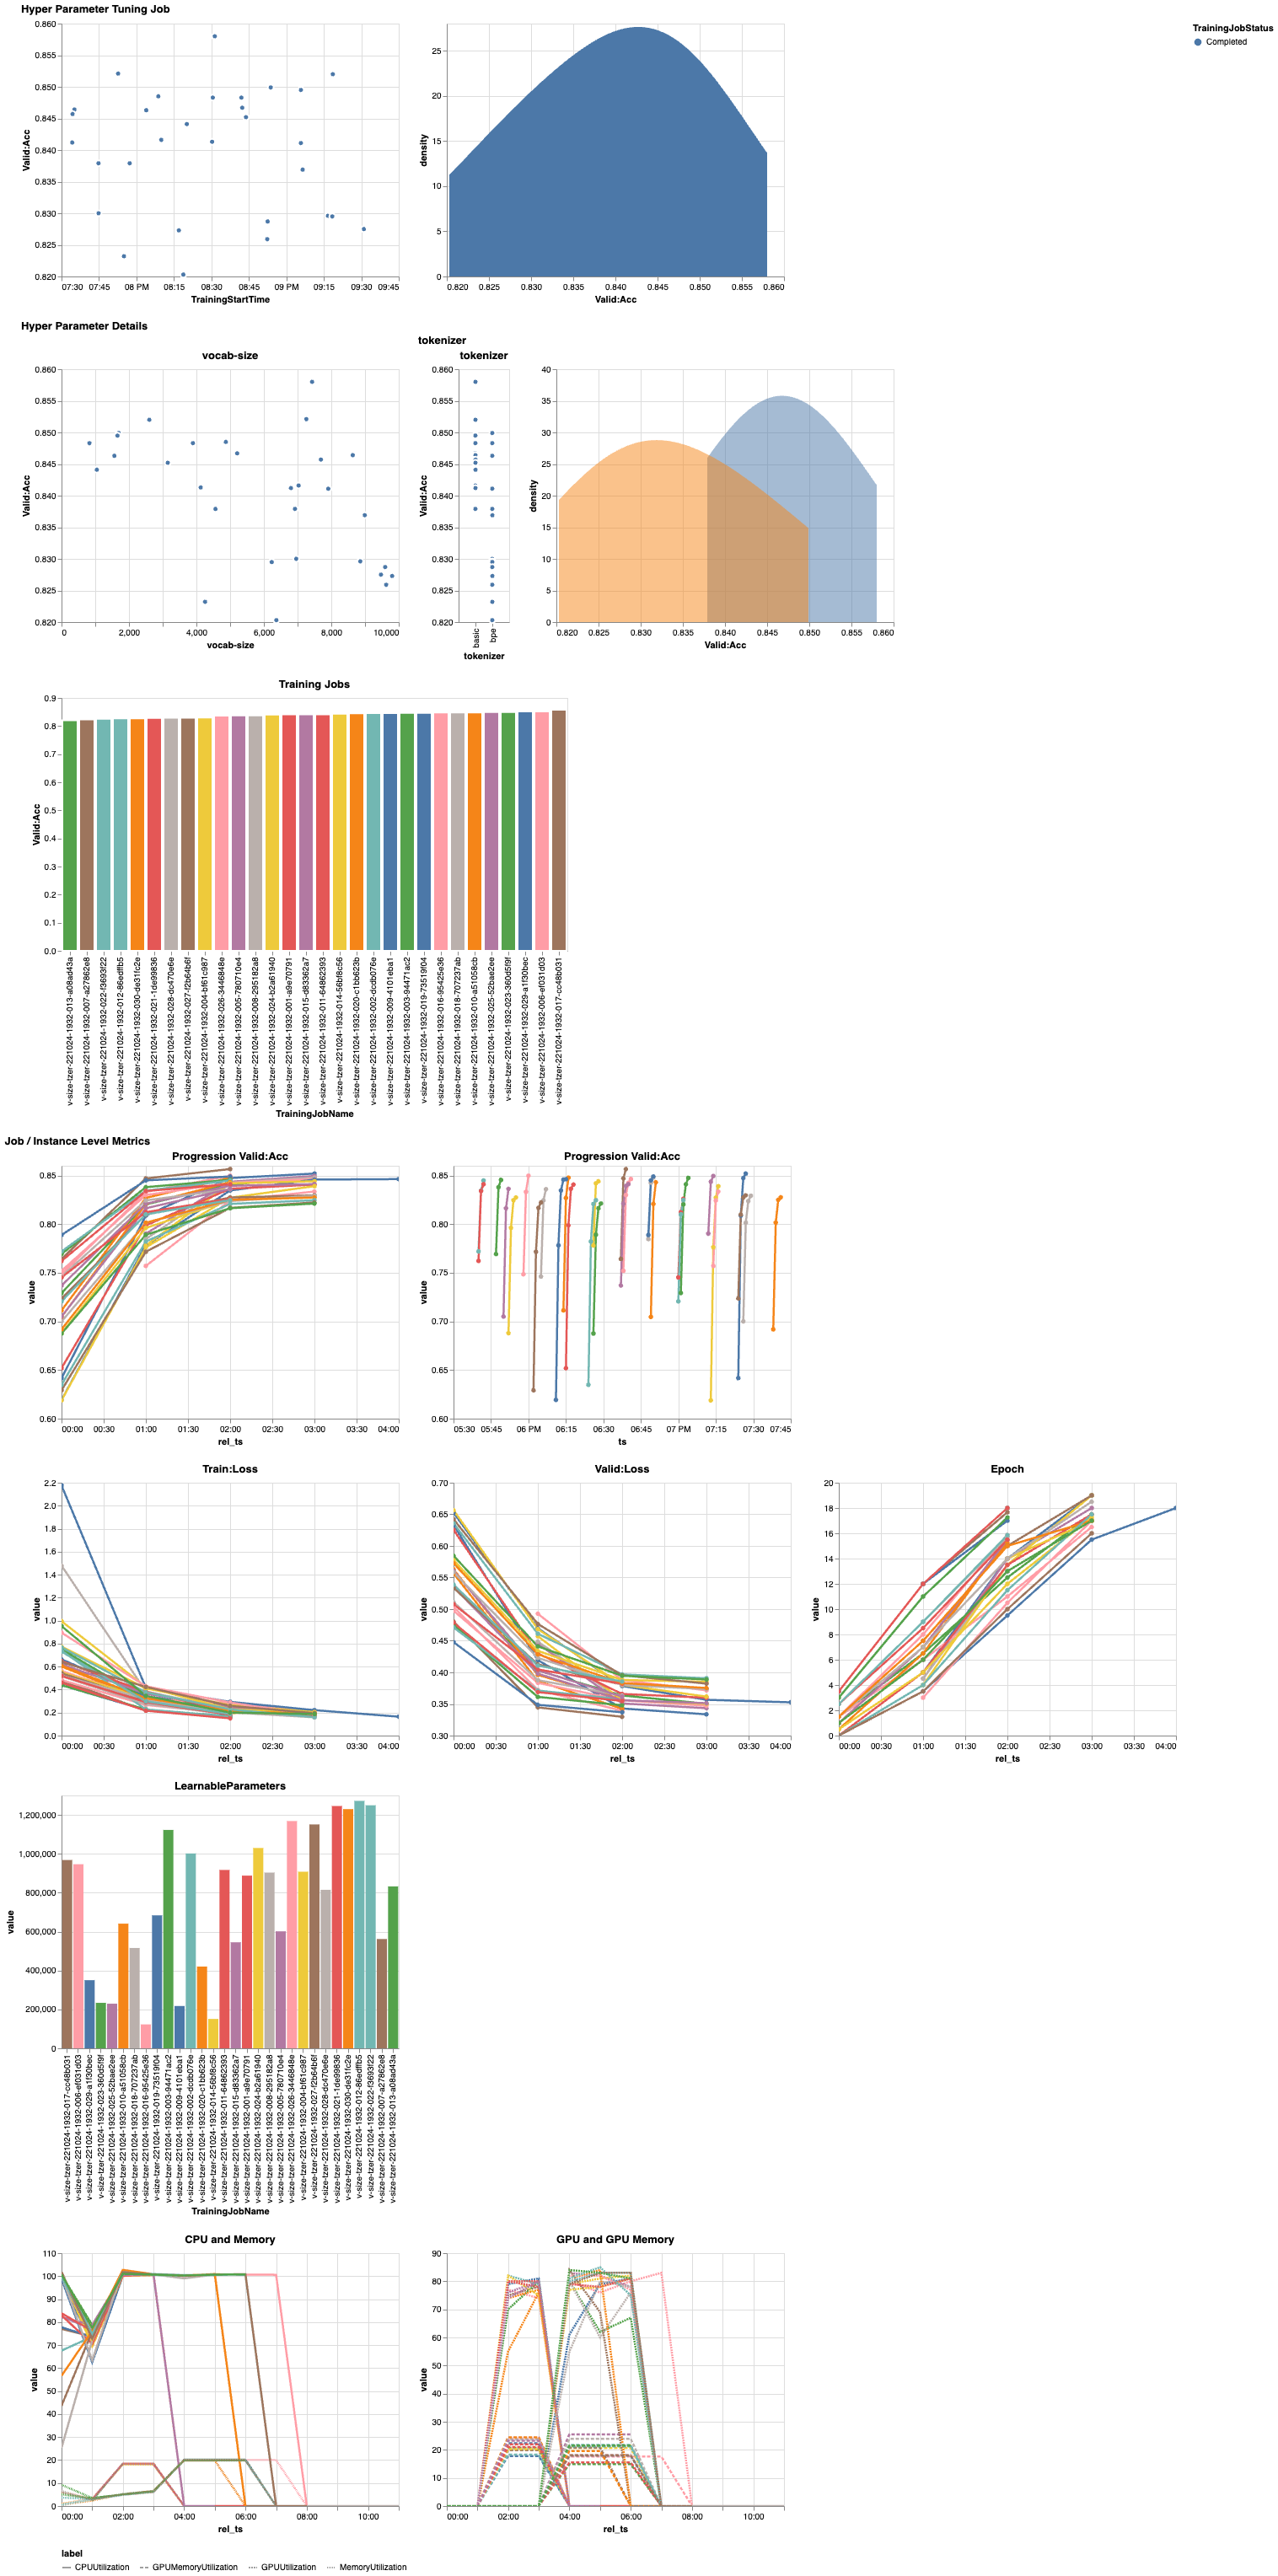

In [12]:
%%time
from reporting_util import analyze_hpo_job
chart, trials_df, full_df = analyze_hpo_job(
    v_size_to, 
    return_dfs=True,
    job_metrics=[
        'Train:Loss',
        'Valid:Loss',
        'Epoch',
        'LearnableParameters'
    ]
)
chart 

In [ ]:
XXX

In [400]:
%%time
import re
import numpy as np
word_counts = np.array([len(re.findall(r'\w+', text)) for _, text in train_dp])
word_counts.shape, np.min(word_counts), np.median(word_counts), word_counts.mean()

CPU times: user 1.17 s, sys: 21.5 ms, total: 1.19 s
Wall time: 1.19 s


((25000,), 10, 181.0, 242.27492)

In [401]:
#!pip install -Uq revtok spacy moses

In [402]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
word_counts_basic = np.array([len(tokenizer(text)) for _, text in train_dp])


%time word_counts_subwords = np.array([len(np.array(list(sp_tokenizer([text]))).flatten()) for _, text in train_dp])

CPU times: user 9.91 s, sys: 63.8 ms, total: 9.97 s
Wall time: 9.98 s


In [219]:
trials_df

max-input-len                      TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
1         1942.0  cnn-in-len-221023-1140-007-4e6cdddf         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
5          794.0  cnn-in-len-221023-1140-003-57d8e790         Completed 2022-10-23 12:04:42+02:00 2022-10-23 12:12:14+02:00                       452.0  cnn-in-len-221023-1140     0.8564
7         2685.0  cnn-in-len-221023-1140-001-b475b819         Completed 2022-10-23 11:42:42+02:00 2022-10-23 11:50:15+02:00                       453.0  cnn-in-len-221023-1140     0.8532
3         2553.0  cnn-in-len-221023-1140-005-70b24897         Completed 2022-10-23 12:26:28+02:00 2022-10-23 12:34:06+02:00                       458.0  cnn-in-len-221023-1140     0.8523
2          607.0  cnn-in-len-221023-1140-006-b11b9323         Completed 2022-10-23 12:37:04+02:00 2022-10-23 12:44:12+02:00                       428.0  cnn-in-len-221023-1140     0.8475
4         3907.0  cnn-in-len-221023-1140-004-a9d9f809         Completed 2022-10-23 12:14:34+02:00 2022-10-23 12:22:33+02:00                       479.0  cnn-in-len-221023-1140     0.8467
6         3136.0  cnn-in-len-221023-1140-002-6355c725         Completed 2022-10-23 11:52:12+02:00 2022-10-23 12:01:01+02:00                       529.0  cnn-in-len-221023-1140     0.8443

In [403]:
df_simple   = pd.DataFrame(data= {'label': 'simple', 'counts': word_counts})
df_basic    = pd.DataFrame(data= {'label': 'basic english', 'counts': word_counts_basic})
df_subwords = pd.DataFrame(data= {'label': 'subwords', 'counts': word_counts_subwords})

df = pd.concat((df_simple, df_basic, df_subwords), axis=0)

In [404]:
# tokenizer = get_tokenizer('subword')
# tokenizer('this is just an test to try out an attempt on a washingmachine unknownwird which is running.')

In [405]:
df.groupby('label').describe()

counts                                                          
                 count       mean         std   min    25%    50%    75%     max
label                                                                           
basic english  25000.0  270.68748  200.185691  11.0  147.0  202.0  329.0  2752.0
simple         25000.0  242.27492  179.876908  10.0  131.0  181.0  295.0  2525.0
subwords       25000.0  366.84840  285.184281  11.0  189.0  269.0  447.0  4294.0

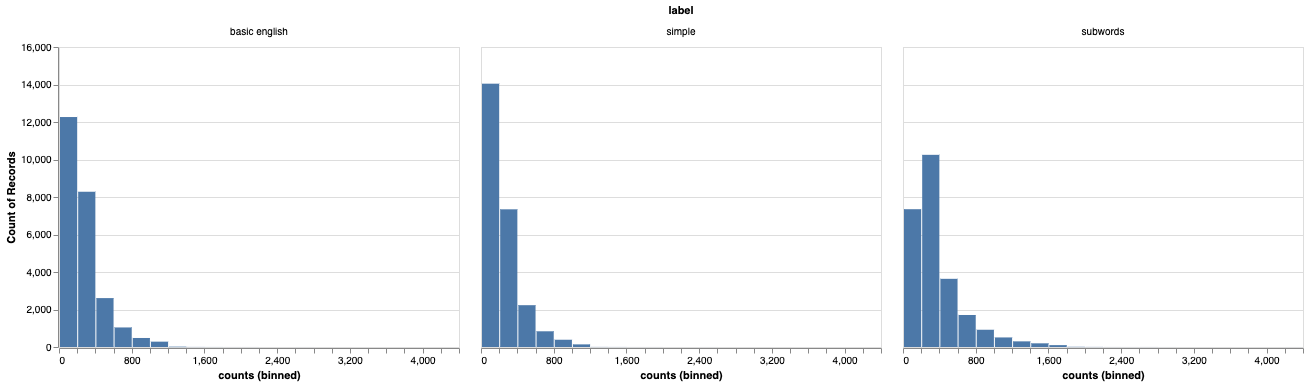

In [406]:
import altair as alt
import pandas as pd
# pd.DataFrame(data={'counts': word_counts}) 
alt.Chart(df).mark_bar().encode( 
    x=alt.X('counts:Q', bin=alt.Bin(maxbins=30), sort=None),
    y='count()',
    tooltip='median(counts)'   
).facet('label:N')

In [412]:
from torchtext.data.functional import generate_sp_model

from pathlib import Path
input_file = Path('data')/'sp_input'
output_dir = Path('data')/'sp_out'

if not input_file.exists():
    with open(input_file, 'w') as f:
        for _, text in train_dp:
            f.write(text+'\n')
if not output_dir.exists():
    output_dir.mkdir(exist_ok=True)

# Outputs, among others: Updating active symbols. max_freq=705466 min_freq=168    
generate_sp_model(str(input_file), vocab_size=4000, model_type='bpe', model_prefix=f'{output_dir}/sp_out')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/sp_input --model_prefix=data/sp_out/sp_out --vocab_size=4000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/sp_input
  input_format: 
  model_prefix: data/sp_out/sp_out
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pa

CPU times: user 4.5 s, sys: 47.3 ms, total: 4.55 s
Wall time: 3.95 s


bpe_model_trainer.cc(258) LOG(INFO) Added: freq=324 size=3780 all=84202 active=4751 piece=▁include
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=322 size=3800 all=84378 active=4927 piece=▁Christopher
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=321 min_freq=119
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=319 size=3820 all=84609 active=4449 piece=ledge
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=317 size=3840 all=84659 active=4499 piece=▁steal
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=315 size=3860 all=84821 active=4661 piece=▁formula
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=312 size=3880 all=85083 active=4923 piece=rick
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=310 size=3900 all=85213 active=5053 piece=▁falling
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=310 min_freq=115
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=308 size=3920 all=85382 active=4430 piece=▁forgotten
trainer_interface.cc(604) LOG(INFO) S

In [174]:
from torchtext.data.functional import load_sp_model
sp_model = load_sp_model('m_user.model')
sp_tokenizer = sentencepiece_tokenizer(sp_model)
l = list(tokenizer(['one two three', 'four five six', 'example to try', 'washing machine running automation']))